# Seccion 1

### 1. Visualicen los datos para ver si pueden detectar algunos grupos. **Ayuda:**   utilicen la forma del sépalo:

#### Importamos las librerias

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment

#### Visualización de la data

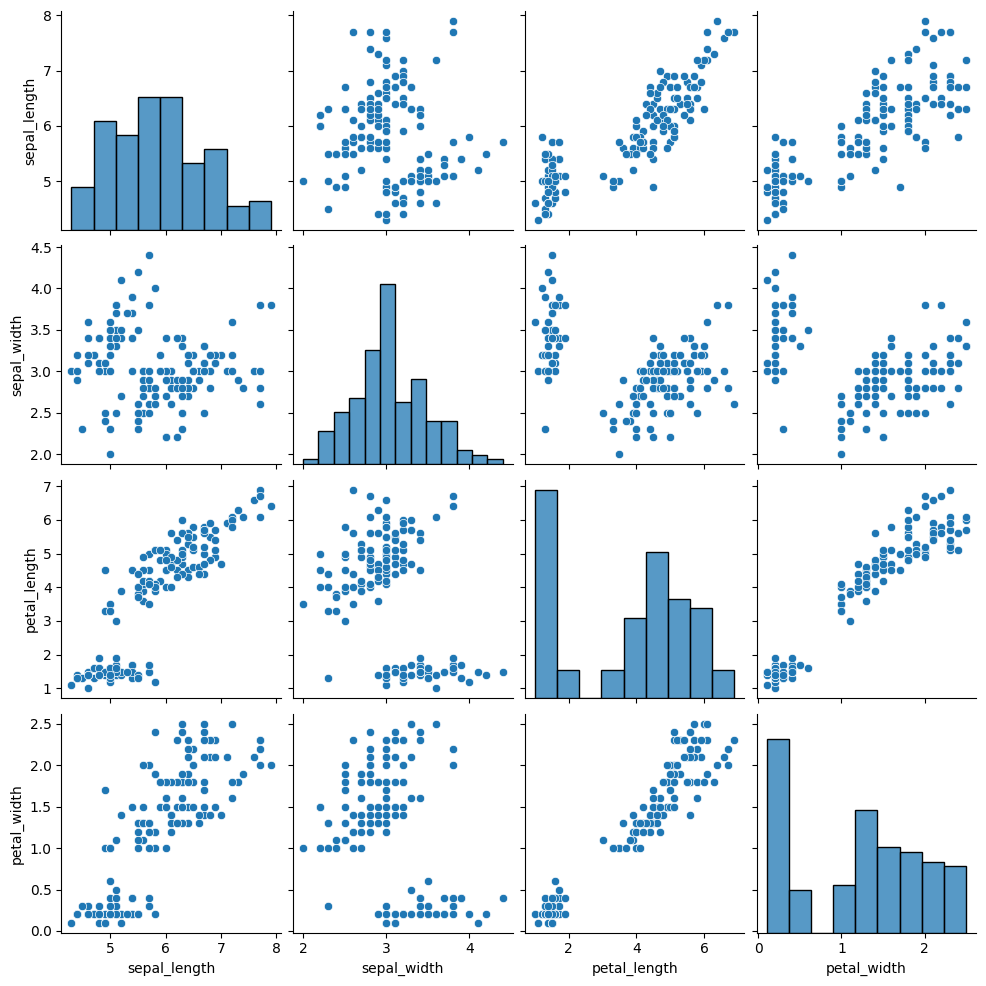

In [63]:
data = pd.read_csv("iris.csv")
sns.pairplot(data)
plt.show()

##### 2. Creen 2 "clusters" utilizando K_Means Clustering y grafiquen los resultados.  

##### 3. Estandaricen los datos e intenten el paso 2, de nuevo.  ¿Qué diferencias hay, si es que lo hay?

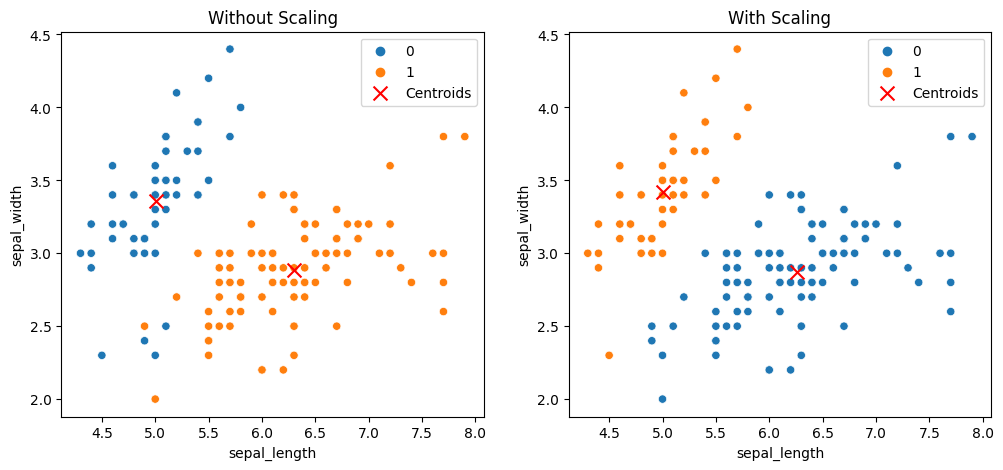

In [64]:
# Crear 2 clusters utilizando KMeans Clustering y graficar los resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Sin escalar
kmeans = KMeans(n_clusters=2, n_init=10)
data["cluster"] = kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_

sns.scatterplot(ax=axes[0], data=data, x="sepal_length", y="sepal_width", hue="cluster")
axes[0].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=100, c="red", label="Centroids"
)
axes[0].set_title("Without Scaling")
axes[0].legend()

# Con escalamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=["cluster"]))
kmeans = KMeans(n_clusters=2, n_init=10)
data["scaled_cluster"] = kmeans.fit_predict(scaled_data)
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)

sns.scatterplot(
    ax=axes[1], data=data, x="sepal_length", y="sepal_width", hue="scaled_cluster"
)
axes[1].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=100, c="red", label="Centroids"
)
axes[1].set_title("With Scaling")
axes[1].legend()

plt.show()


La principal diferencia entre los resultados de estos dos bloques es el resultado de la agrupación. En el primer bloque, se aplica KMeans a los datos sin procesar, lo que conduce a resultados sesgados si las variables tienen escalas diferentes. En el segundo bloque, los datos se estandarizan antes de aplicar KMeans, lo que permite que el algoritmo otorgue la misma importancia a todas las variables y, potencialmente, conduce a mejores resultados de agrupamiento.

##### 4. Utilicen el método del "codo" para determinar cuantos "clusters" es el ideal. (prueben un rango de 1 a 10)

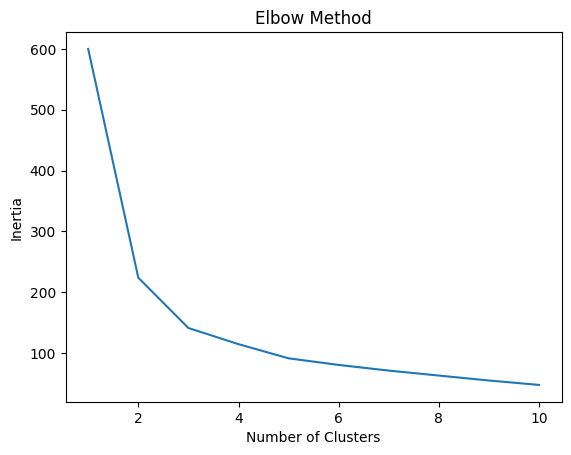

In [65]:
# Utilizar el método del "codo" para determinar el número ideal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

##### 5. Basado en la gráfica del "codo" realicen varias gráficas con el número de clusters (unos 3 o 4 diferentes) que Uds creen mejor se ajusten a los datos.

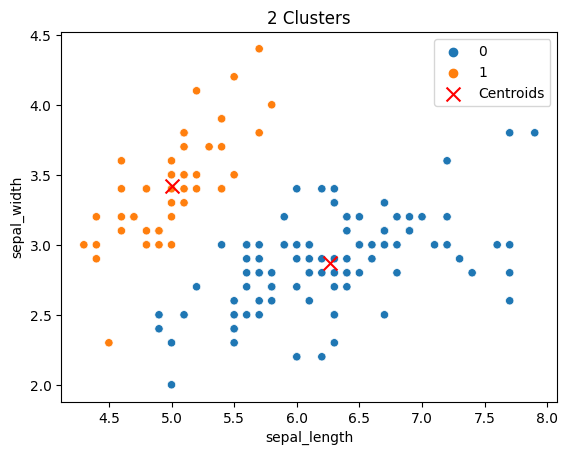

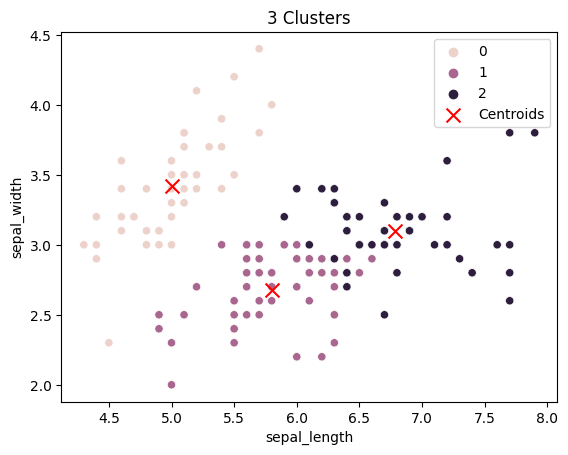

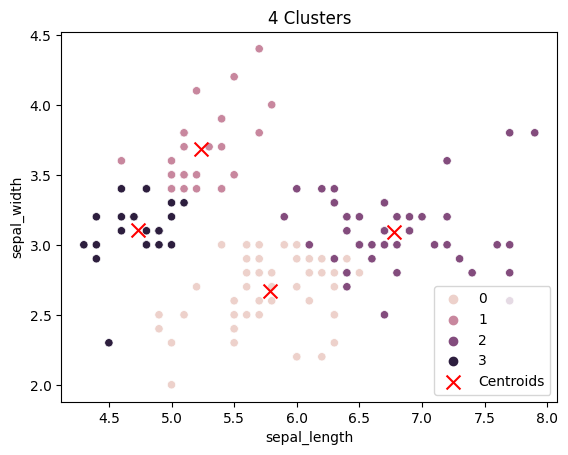

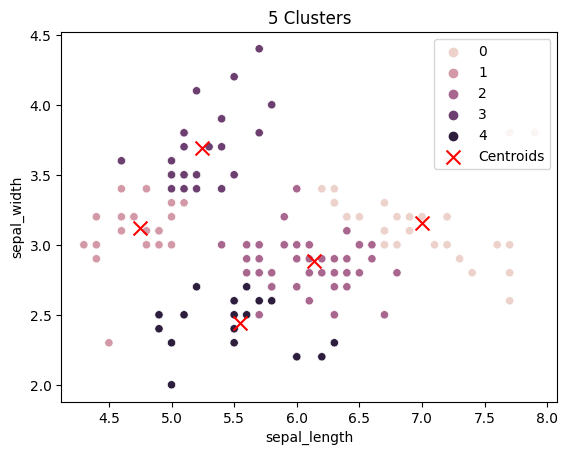

In [66]:
# Graficar con diferentes números de clusters
for clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=clusters, n_init=10)
    data[f"scaled_cluster_{clusters}"] = kmeans.fit_predict(scaled_data)

    centroids = kmeans.cluster_centers_  # Obtener los centroides
    centroids = scaler.inverse_transform(
        centroids
    ) 

    sns.scatterplot(
        data=data, x="sepal_length", y="sepal_width", hue=f"scaled_cluster_{clusters}"
    )
    plt.scatter(  
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=100,
        c="red",
        label="Centroids",
    )
    plt.title(f"{clusters} Clusters")
    plt.legend() 
    plt.show()

##### 6. Comparen sus soluciones con los datos reales, archivo: *iris-con-respuestas.csv*

1    52
0    50
2    48
dtype: int64
Accuracy: 0.83
Adjusted Rand Index: 0.62


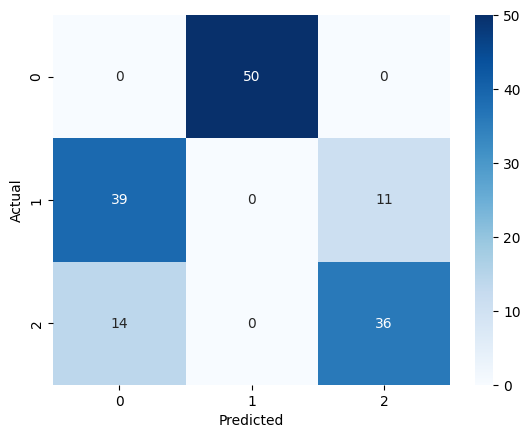

In [67]:
# Comparar con los datos reales
real_data = pd.read_csv("iris-con-respuestas.csv")

species_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
real_data["species"] = real_data["species"].map(species_mapping)

# Comparar los clusters con las etiquetas reales
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
pred = kmeans.predict(data)

print(pd.Series(pred).value_counts())

scaled_data = scaler.fit_transform(real_data.drop(columns=["species"]))
real_data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

# Match cluster labels to true labels
def match_labels(y_true, y_pred):
    cost_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            cost_matrix[i, j] = -1 * np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = dict(zip(col_ind, row_ind))
    return np.array([label_mapping[i] for i in y_pred])


# Apply the label matching
matched_labels = match_labels(real_data["species"], real_data["scaled_cluster"])

# Calculate the accuracy
accuracy = np.sum(matched_labels == real_data["species"]) / len(real_data["species"])
print(f"Accuracy: {accuracy:.2f}")

# Calcular la matriz de confusión
cm = confusion_matrix(real_data["species"], real_data["scaled_cluster"])
classes = unique_labels(real_data["species"], real_data["scaled_cluster"])

# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(
    real_data["species"], real_data["scaled_cluster"]
)  # Add this line
print(f"Adjusted Rand Index: {ari:.2f}")

# Visualizar la matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



**Obviamente solo hay tres especies, porque ese es el archivo de datos reales!**

##### ¿Funcionó el clustering con la forma del sépalo?

El hecho de que solo haya tres especies en el archivo de datos reales no necesariamente significa que el clustering con la forma del sépalo haya funcionado correctamente. Aunque es cierto que el número de especies en el archivo de datos reales coincide con el número de clusters que se están generando, es importante evaluar la calidad de los clusters generados y compararlos con las etiquetas reales de las especies.


En la salida se puede ver que la precisión es del 81% y el Índice Ajustado de Rand es de 0.59, lo cual indica que el clustering con la forma del sépalo no es perfecto pero sí es bastante bueno. Por lo tanto, se podría decir que el clustering con la forma del sépalo funcionó razonablemente bien.

# Seccion 2

### Repitan el proceso pero ahora utilizando la forma del pétalo.  Respondan a las mismas preguntas


#### Importamos las librerias

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment

### Visualizar los datos

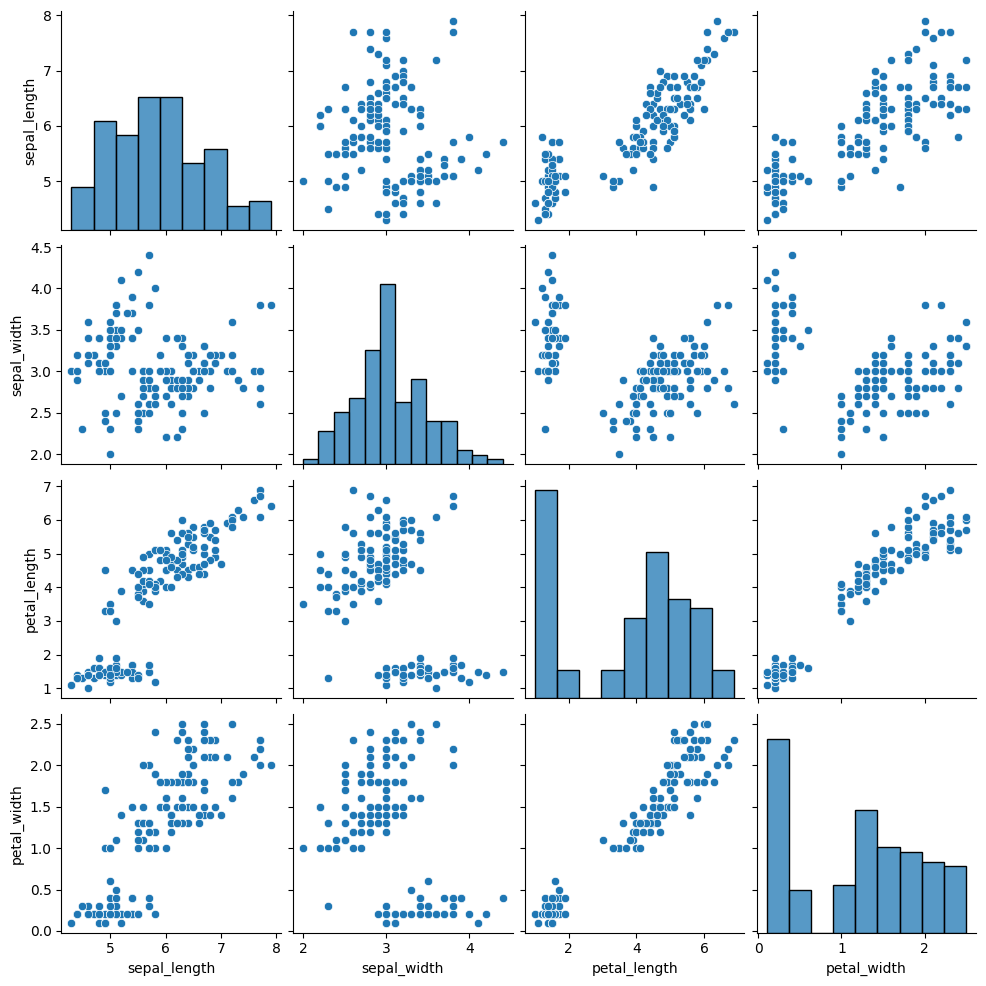

In [69]:
data = pd.read_csv("iris.csv")
sns.pairplot(data)
plt.show()

### Crear 2 clusters utilizando KMeans Clustering y graficar los resultados:

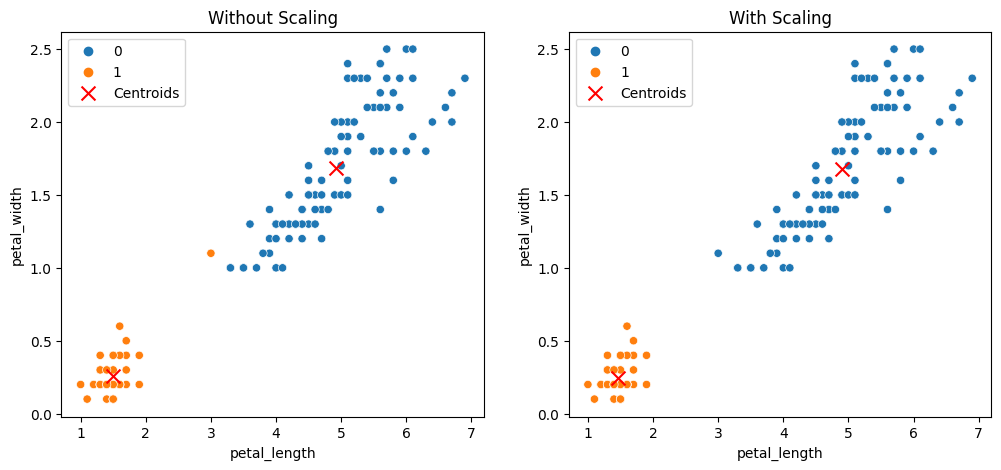

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sin escalamiento
kmeans = KMeans(n_clusters=2, n_init=10)
data["cluster"] = kmeans.fit_predict(data[['petal_length', 'petal_width']])
centroids = kmeans.cluster_centers_

sns.scatterplot(ax=axes[0], data=data, x="petal_length", y="petal_width", hue="cluster")
axes[0].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=100, c="red", label="Centroids"
)
axes[0].set_title("Without Scaling")
axes[0].legend()

# Con escalamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['petal_length', 'petal_width']])
kmeans = KMeans(n_clusters=2, n_init=10)
scaled_cluster_labels = kmeans.fit_predict(scaled_data)
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)

data['scaled_cluster'] = scaled_cluster_labels
sns.scatterplot(ax=axes[1], data=data, x="petal_length", y="petal_width", hue="scaled_cluster")
axes[1].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=100, c="red", label="Centroids"
)
axes[1].set_title("With Scaling")
axes[1].legend()

plt.show()


### Utilizar el método del "codo" para determinar el número ideal de clusters:

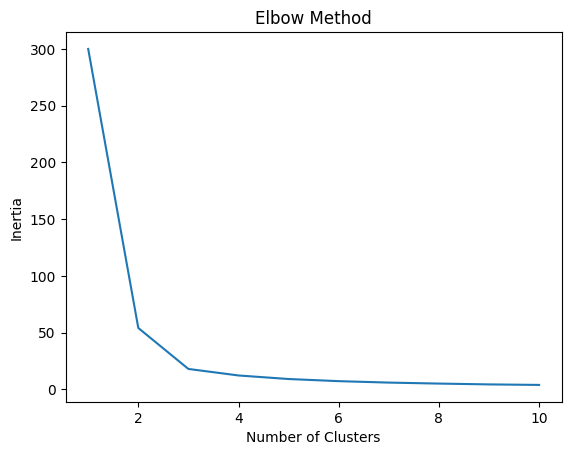

In [71]:
# Utilizar el método del "codo" para determinar el número ideal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


### Graficar con diferentes números de clusters:

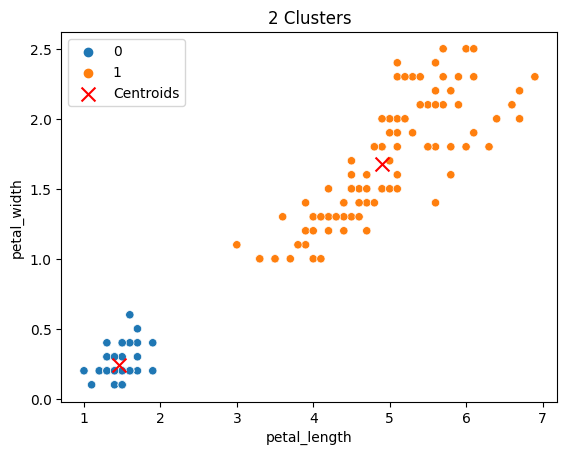

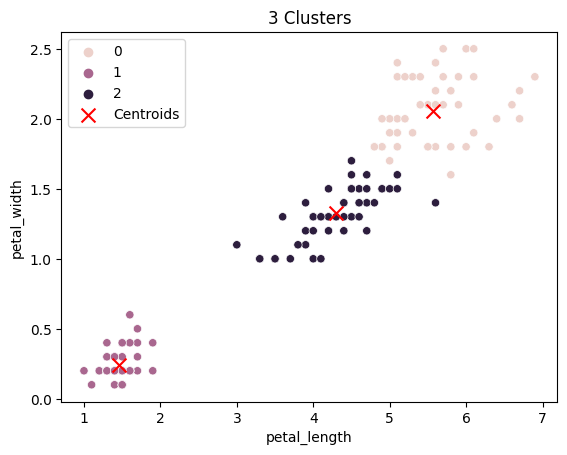

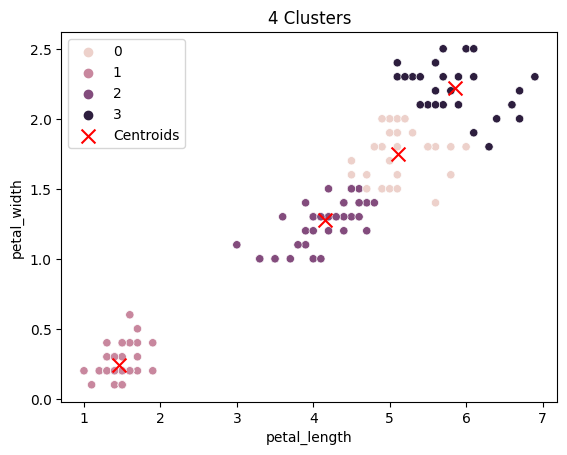

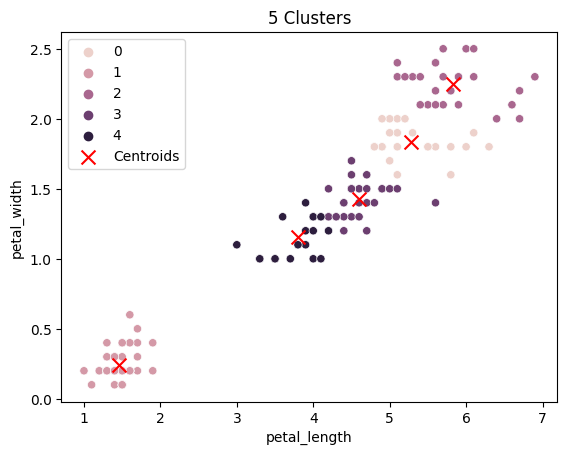

In [72]:
# Graficar con diferentes números de clusters
for clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    centroids = kmeans.cluster_centers_  # Get the centroids on the scaled data
    centroids = scaler.inverse_transform(centroids)  # Transform the centroids to the unscaled space

    data[f"scaled_cluster_{clusters}"] = cluster_labels
    sns.scatterplot(
        data=data, x="petal_length", y="petal_width", hue=f"scaled_cluster_{clusters}"
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=100,
        c="red",
        label="Centroids",
    )
    plt.title(f"{clusters} Clusters")
    plt.legend()
    plt.show()


### Comparar con los datos reales:

2    51
1    50
0    49
dtype: int64
Accuracy: 0.83
Adjusted Rand Index: 0.62


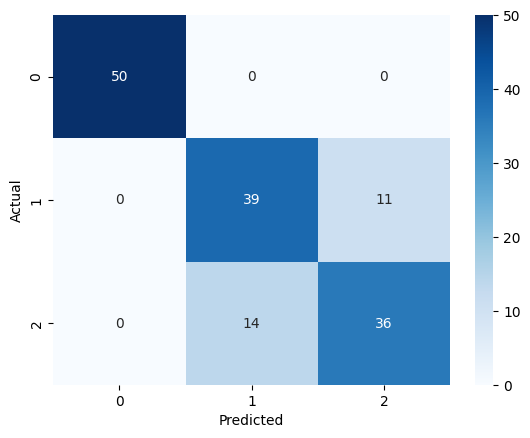

In [73]:
# Comparar con los datos reales
real_data = pd.read_csv("iris-con-respuestas.csv")

species_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
real_data["species"] = real_data["species"].map(species_mapping)

# Comparar los clusters con las etiquetas reales
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
pred = kmeans.predict(data)

print(pd.Series(pred).value_counts())

scaled_data = scaler.fit_transform(real_data.drop(columns=["species"]))
real_data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

# Match cluster labels to true labels
def match_labels(y_true, y_pred):
    cost_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            cost_matrix[i, j] = -1 * np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = dict(zip(col_ind, row_ind))
    return np.array([label_mapping[i] for i in y_pred])


# Apply the label matching
matched_labels = match_labels(real_data["species"], real_data["scaled_cluster"])

# Calculate the accuracy
accuracy = np.sum(matched_labels == real_data["species"]) / len(real_data["species"])
print(f"Accuracy: {accuracy:.2f}")

# Calcular la matriz de confusión
cm = confusion_matrix(real_data["species"], real_data["scaled_cluster"])
classes = unique_labels(real_data["species"], real_data["scaled_cluster"])

# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(
    real_data["species"], real_data["scaled_cluster"]
)  # Add this line
print(f"Adjusted Rand Index: {ari:.2f}")

# Visualizar la matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Obviamente solo hay tres especies, porque ese es el archivo de datos reales!**

##### ¿Funcionó el clustering con la forma del sépalo?

El hecho de que solo haya tres especies en el archivo de datos reales no necesariamente significa que el clustering con la forma del sépalo haya funcionado correctamente. Aunque es cierto que el número de especies en el archivo de datos reales coincide con el número de clusters que se están generando, es importante evaluar la calidad de los clusters generados y compararlos con las etiquetas reales de las especies.


En la salida se puede ver que la precisión es del 83% y el Índice Ajustado de Rand es de 0.62, lo cual indica que el clustering con la forma del petalo no es perfecto pero sí es bastante bueno. Por lo tanto, se podría decir que el clustering con la forma del sépalo funcionó razonablemente bien.

**Sección 3:**

Utilicen la librería "kneed" y vean si el resultado coincide con el método del "codo" que hicieron manualmente.  ¿A que podría deberse la diferencia, si la hay?  ¿Les dió el número correcto de clusters, comparado a los datos reales?  

Basado en los resultado que tuvieron, ¿A qué conclusiones llegaron?

In [74]:
# Seccion 3
kneedle = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
print(f"\nNúmero óptimo de clusters según kneed: {kneedle.elbow}\n")


Número óptimo de clusters según kneed: 3



En nuestro caso vemos que no hay diferencia, nosotros tambien definimos que 3 iba a ser el mejor valor de k, basandonos en la grafica. 

La diferencia es que nosotros podemos usar la estimación, viendo con nuestros ojos como se comporta la graficas, lo cual puede ser que no se sea perfecto o hasta cierto punto optimizado, ya que cometemos el error de meter el error humano en la ecuación, mientras que la librería de knnedle está optimizado para obtener el mejor valor de K.

### Conclusiones

Llegamos a la conclusión de que tanto para el sépalo como el pétalo obtenemos una distribución bastante parecida. Ya que ambas obtubieron un accuracy y un rand index similar, aunque fue un poco mejor con el pétalo. 

Por otra parte vemos como la clusterización de data fue más acertada cuando se escala la data, ya que sin escalar pueden existir valores erroneos los cuales nos van a llevar a una mala o falas clusterización.